In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

from scripts.export_csv_to_sql import *

warnings.filterwarnings("ignore")

In [2]:
#Criando a conexão com o banco de dados criado
conn = create_connection("microdata_enem_2023.db")


In [3]:
#Selecionando apenas os dados de estudantes maranhenses e com nota não nula na redação
query = open("scripts_sql/refined_data_query.sql", "r").read()
df = pd.read_sql(query, conn)

In [4]:
#Descartando as variáveis não importantes para o problema:

variaveis_nao_importantes = [
    "NO_MUNICIPIO_ESC",
    "NO_MUNICIPIO_PROVA",
    "SG_UF_ESC",
    "SG_UF_PROVA",
    "TP_PRESENCA_CN",
    "TP_PRESENCA_CH",
    "TP_PRESENCA_LC",
    "TP_PRESENCA_MT",
    "CO_PROVA_CN",
    "CO_PROVA_CH",
    "CO_PROVA_LC",
    "CO_PROVA_MT",
    "TP_LINGUA",
    "TP_STATUS_REDACAO",
    "NU_NOTA_COMP1",
    "NU_NOTA_COMP2",
    "NU_NOTA_COMP3",
    "NU_NOTA_COMP4",
    "NU_NOTA_COMP5"
]

In [5]:
variaveis_numericas = [
    "NU_NOTA_CN",
    "NU_NOTA_CH",
    "NU_NOTA_LC",
    "NU_NOTA_MT",
]

In [6]:
#Utilizando apendas as variáveis categóricas relacionados a dados da escola ou dados demográficos
variaveis_categoricas = [coluna for coluna in df.columns if (coluna not in variaveis_nao_importantes) and (coluna not in variaveis_numericas)]

In [7]:
#Transformando as colunas categoricas para o tipo original
for coluna in variaveis_categoricas:
    df[coluna] = df[coluna].astype('category')

In [8]:
#Transformando as colunas numericas para o tipo original
for coluna in variaveis_numericas:
    df[coluna] = df[coluna].astype(float)

In [9]:
df = df[variaveis_categoricas + variaveis_numericas].reset_index(drop=True)

In [10]:
#Removendo todos os registros que contem ao menos um valor nulo
df = df.dropna()

In [11]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split

In [12]:
# Creating a funtion to summarize dataframe information

def data_summary(df):
    '''Summary dataframe information'''

    df = pd.DataFrame({'type': df.dtypes,
                       'unique': df.nunique()})
    return df

In [13]:
data_summary(df).head()

,type,unique
TP_FAIXA_ETARIA,category,15
TP_SEXO,category,2
TP_ESTADO_CIVIL,category,5
TP_COR_RACA,category,6
TP_NACIONALIDADE,category,5


In [11]:
df["NU_NOTA_REDACAO"] = df["NU_NOTA_REDACAO"].astype(float)
df = df[df["NU_NOTA_REDACAO"] > 0]

In [15]:
fitted_data, fitted_lambda = stats.yeojohnson(df["NU_NOTA_REDACAO"])

<Axes: ylabel='Count'>

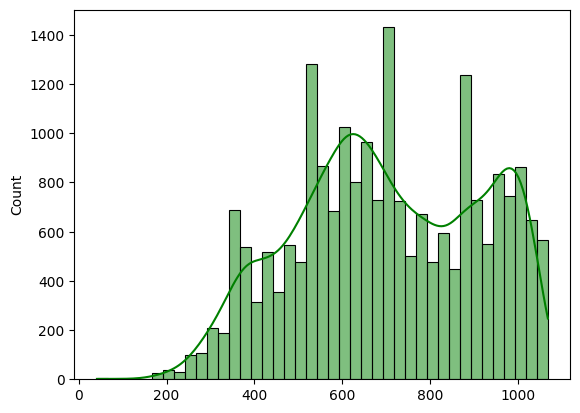

In [16]:
sns.histplot(fitted_data, kde=True, 
            label = "Non-Normal", color ="green")

<Axes: xlabel='NU_NOTA_REDACAO', ylabel='Count'>

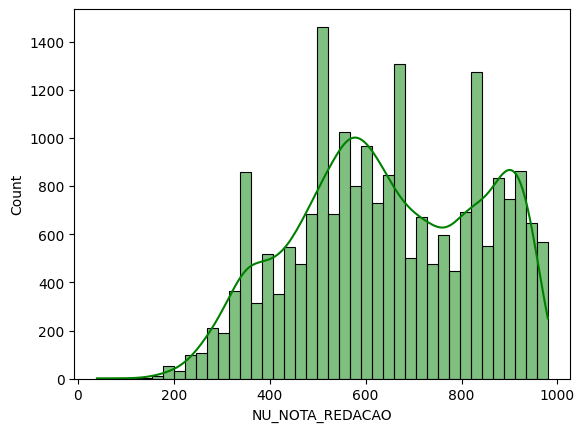

In [17]:
sns.histplot(df["NU_NOTA_REDACAO"], kde=True, 
            label = "Non-Normal", color ="green")

In [15]:
X = pd.get_dummies(df.drop(columns=['NU_NOTA_REDACAO'], errors="ignore"), drop_first=True)
y = df["NU_NOTA_REDACAO"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

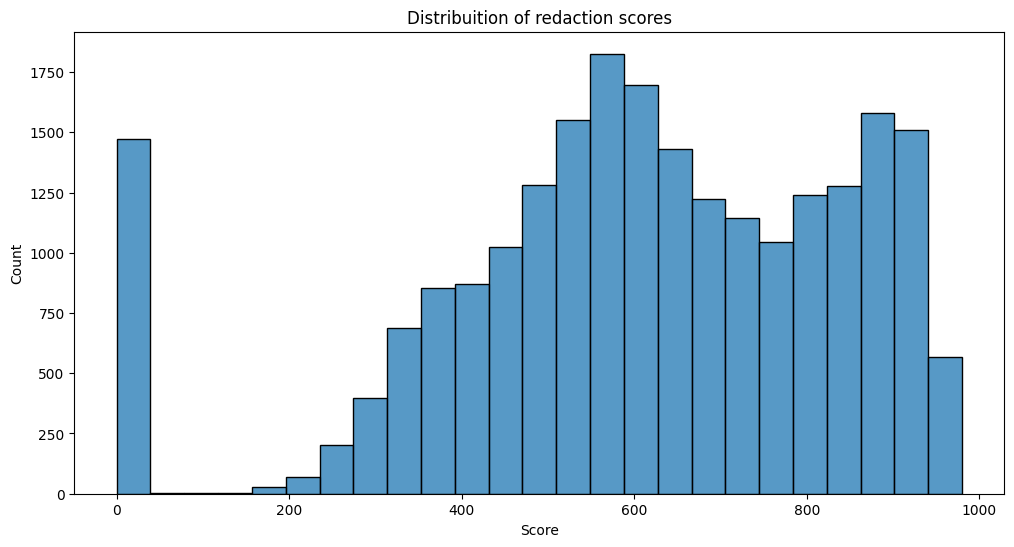

In [36]:
# Checking the distribution of the variable:
plt.figure(figsize=(12,6))
sns.histplot(df.NU_NOTA_REDACAO, bins=25)
plt.xlabel('Score')
plt.title('Distribuition of redaction scores')
plt.show()

In [31]:
# selector = SelectKBest(score_func=chi2, k=15)  # Select top 15 features
# X_train_selected = selector.fit_transform(X_train, y_train)

# fit = selector.fit(X_train, y_train)
# mask = fit.get_support()

# Get the names of the selected features
# selected_features = X.columns[mask]

# print("Selected Features:")
# print(selected_features)

In [32]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Displaying scores for each feature
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print(feature_scores.sort_values(by='Score', ascending=False))

                      Feature        Score
2                  NU_NOTA_LC  9002.033507
3                  NU_NOTA_MT  8833.653402
1                  NU_NOTA_CH  8363.510051
0                  NU_NOTA_CN  5802.978985
76   TP_DEPENDENCIA_ADM_ESC_4  2886.741599
..                        ...          ...
173                    Q015_D     0.000000
174                    Q015_E     0.000000
177                    Q016_D     0.000000
11         TP_FAIXA_ETARIA_17     0.000000
60             IN_TREINEIRO_1     0.000000

[200 rows x 2 columns]


In [33]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

model = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
scores = absolute(scores)

print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 115.125 (1.992)


In [34]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
x_result = model.predict(X_test)

In [36]:
x_result

array([613.724  , 479.06342, 700.7722 , ..., 726.1725 , 787.51306,
       632.6223 ], dtype=float32)

In [37]:
y_test

70352     440.0
111861    240.0
17466     680.0
63128     680.0
9724      880.0
          ...  
53594     900.0
92887     540.0
101803    720.0
47017     660.0
83448     680.0
Name: NU_NOTA_REDACAO, Length: 4302, dtype: float64

In [39]:
import numpy as np

# Função para arredondar o valor para o múltiplo mais próximo de 20, no intervalo [0, 1000]
def adjust_prediction(pred):
    # Arredondar para o múltiplo de 20 mais próximo
    adjusted_pred = round(pred / 20) * 20
    # Garantir que o valor esteja no intervalo de 0 a 1000
    return max(0, min(adjusted_pred, 1000))

# Ajustando a predição
x_result = np.array([adjust_prediction(x) for x in x_result])

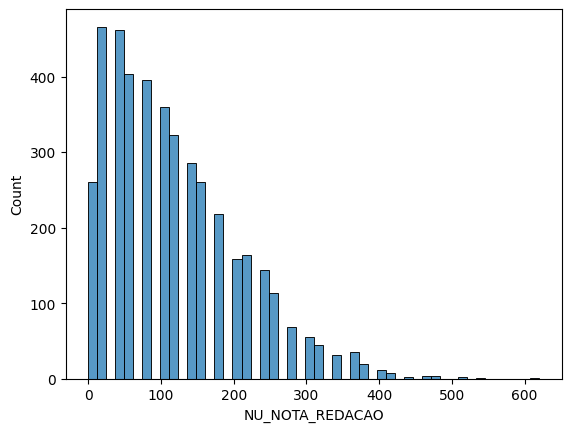

In [42]:
sns.histplot(absolute(x_result - y_test), bins=50)
plt.show()

In [58]:
import numpy as np

# Função para arredondar o valor para o múltiplo mais próximo de 20, no intervalo [0, 1000]
def adjust_prediction(pred):
    # Arredondar para o múltiplo de 20 mais próximo
    adjusted_pred = round(pred / 20) * 20
    # Garantir que o valor esteja no intervalo de 0 a 1000
    return max(0, min(adjusted_pred, 1000))

# Ajustando a predição
x_result = np.array([adjust_prediction(x) for x in x_result])


In [59]:
x_result

array([620, 660, 520, ..., 920, 680, 900])

In [60]:
y_test

70689    580.0
57923    500.0
51048      0.0
57504    440.0
96783    800.0
         ...  
45998    960.0
75826    600.0
85671    960.0
5699     520.0
30880    780.0
Name: NU_NOTA_REDACAO, Length: 4597, dtype: float64

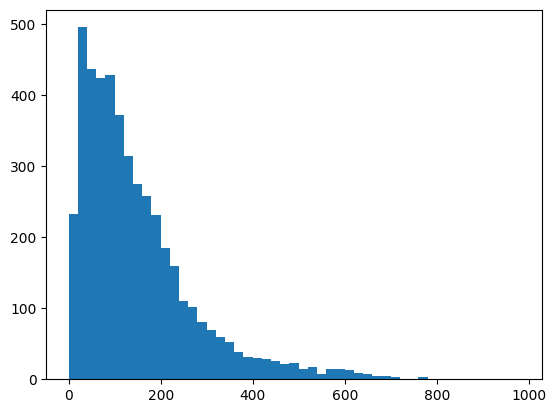

In [64]:
plt.hist(absolute(x_result - y_test), bins=np.arange(0, 1000, 20))
plt.show()

In [13]:
from pycaret.regression import *

In [15]:
# Creating a pipeline to setup the model
pipeline = setup(data=df, 
                 target='NU_NOTA_REDACAO', 
                 remove_multicollinearity=True,
                 normalize_method='minmax',
                 multicollinearity_threshold=0.95, 
                 normalize=True, 
                 transform_target=False,
                 session_id=1)

,Description,Value
0,Session id,1
1,Target,NU_NOTA_REDACAO
2,Target type,Regression
3,Original data shape,"(21508, 43)"
4,Transformed data shape,"(21508, 181)"
5,Transformed train set shape,"(15055, 181)"
6,Transformed test set shape,"(6453, 181)"
7,Numeric features,4
8,Categorical features,38
9,Preprocess,True


In [ ]:
compare_models(fold=10)

In [16]:
model = create_model('gbr', fold=10, round=3)

In [17]:
df_predict = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,112.0675,20219.0128,142.1936,0.4495,0.2583,0.2111


In [72]:
print(model)

GradientBoostingRegressor(random_state=1)


In [18]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [75]:
df_predict[["NU_NOTA_REDACAO", "prediction_label"]].head()

,NU_NOTA_REDACAO,prediction_label
37489,460.0,467.199224
116390,580.0,684.298674
104998,660.0,587.574418
66360,920.0,526.039947
67986,700.0,608.082712


In [76]:
df_predict

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,SG_UF_PROVA,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,prediction_label
37489,3,F,1,3,1,2,0,2,1,0,MA,2,1,1,MA,C,C,A,A,6,A,A,B,D,A,A,B,A,A,A,A,A,A,B,A,A,C,A,A,B,371.200012,419.399994,432.299988,395.500000,460.0,467.199224
116390,2,F,1,3,1,2,0,2,1,0,MA,2,1,1,MA,E,F,B,B,4,E,A,B,C,A,A,B,A,A,A,A,A,A,B,A,B,D,A,A,B,476.000000,523.400024,485.299988,426.600006,580.0,684.298674
104998,3,F,1,3,1,2,0,2,1,0,MA,2,1,1,MA,E,E,D,B,5,E,A,B,D,A,B,B,A,A,A,A,A,A,B,A,B,E,A,A,B,452.299988,480.399994,446.500000,437.899994,660.0,587.574418
66360,4,M,1,1,1,2,0,2,1,0,MA,2,1,1,MA,H,G,D,D,5,D,A,C,D,A,B,B,A,B,A,A,A,A,B,A,A,B,A,A,B,443.899994,385.299988,512.700012,416.399994,920.0,526.039947
67986,3,F,1,2,1,2,0,2,1,0,MA,2,1,1,MA,D,E,B,F,4,B,A,A,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B,423.799988,485.700012,488.600006,423.500000,700.0,608.082712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24795,2,F,1,3,1,2,0,2,1,0,MA,2,2,1,MA,B,D,F,A,7,B,A,B,D,A,A,B,A,A,A,A,A,A,A,A,A,B,A,A,B,413.200012,376.200012,503.700012,398.200012,340.0,549.639040
54012,2,M,1,1,1,2,0,2,1,0,MA,2,1,1,MA,E,E,B,D,4,F,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,D,A,B,B,598.400024,649.500000,683.700012,654.099976,820.0,803.942985
20350,3,F,1,3,1,2,0,2,1,0,MA,1,2,1,MA,D,E,C,D,5,C,A,B,C,B,A,B,A,A,A,A,A,A,A,A,A,C,A,A,B,451.899994,591.700012,595.700012,634.200012,940.0,818.816053
100425,4,M,1,1,1,2,0,2,1,0,MA,2,1,1,MA,E,E,B,F,4,C,A,C,C,B,B,B,A,B,A,A,A,B,B,A,B,E,A,B,B,548.799988,598.799988,486.299988,468.100006,460.0,594.489717


In [99]:
df_transformado = get_config('dataset_transformed')
treino = get_config('train_transformed')
teste = get_config('test_transformed')

In [96]:
teste = get_config('test')

In [97]:
teste["Q025"].value_counts()

Q025
B    5231
A    1222
Name: count, dtype: int64

In [38]:
[coluna for coluna in teste.columns if coluna.startswith("Q0") and "_" not in coluna]

['Q018', 'Q020', 'Q021', 'Q023', 'Q025']

In [80]:
model_object, filename = save_model(model, 'saved_gbr_model')

Transformation Pipeline and Model Successfully Saved


In [81]:
model_object

Pipeline(memory=Memory(location=None),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(include=['NU_NOTA_CN', 'NU_NOTA_CH',
                                             'NU_NOTA_LC', 'NU_NOTA_MT'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapp...
                                                                    'Q011',
                                                                    'Q012',
                                                                    'Q013',
                                                                    'Q014',
                                                                    'Q015',
                                                                    'Q016',
                                                                    'Q017',
                                                                    'Q019',
                                                                    'Q022', ...],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('remove_multicollinearity',
                 TransformerWrapper(exclude=[],
                                    transformer=RemoveMulticollinearity(threshold=0.95))),
                ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                ('trained_model', GradientBoostingRegressor(random_state=1))])

In [ ]:
model = tune_model(model, return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,114.1006,20416.9506,142.8879,0.4464,0.2578,0.2152
1,111.4415,19584.3525,139.9441,0.4416,0.2454,0.2011
2,112.7419,20035.5495,141.5470,0.4568,0.2626,0.2188
3,108.0462,18650.4421,136.5666,0.4842,0.2413,0.1971
4,114.2205,20412.7844,142.8733,0.4352,0.2507,0.2066
5,109.4190,18785.4314,137.0600,0.4601,0.2476,0.2058
6,114.4524,20140.5267,141.9173,0.4624,0.2549,0.2133
7,110.8473,19377.2943,139.2024,0.4197,0.2448,0.1996
8,110.3107,19121.3354,138.2799,0.4683,0.2452,0.2002


Fitting 10 folds for each of 10 candidates, totalling 100 fits


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt',
                          min_impurity_decrease=0.05, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=260, random_state=1,
                          subsample=0.8)